In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from ipfn import ipfn
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
provider = OriginDestinationEmploymentDataProvider()

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance

%matplotlib inline

In [26]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

## Example: unconstrained log-MSE gravity model

In [61]:
def predict_unconstrained_log_mse(edges):
    '''
    Input: Pandas dataframe with origin, destination, distance, jobs, residence and flow columns
    Output; dataframe with with model predictions in 'predicted_flow' column
    '''
    copy = edges.copy()
    # replace zero values with 1
    copy.loc[(copy['jobs'] == 0), 'jobs'] = 1 
    copy.loc[(copy['residence'] == 0), 'residence'] = 1
    
    X = sm.add_constant(np.log(copy.distance))
    y = np.log(edges['flow']) - np.log(copy.jobs) - np.log(copy.residence)
    
    model = sm.OLS(y, X).fit()
    prediction = model.predict(X)
    copy['predicted_flow'] = np.exp(prediction + np.log(copy.jobs) + np.log(copy.residence))
    
    return copy[['origin', 'destination', 'flow', 'predicted_flow']]

## Mingyi and Devashish, please add your models below:

In [ ]:
# prediction functions that take a Pandas dataframe with origin, destination, distance, jobs, residence and flow columns
# and return a dataframe with 'origin', 'destination', 'flow', 'predicted_flow' columns


In [64]:
# get data for above cities - census tract level

prediction = {}
target_columns = ['SE01', 'SE02', 'SE03']

for city, state, conties in cities:
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    with_distance = add_distance(city_network).edges
    # set distance to 0.2 for cycle edges
    with_distance.loc[with_distance.distance == 0, 'distance'] = 0.2
    print(f"Processing {city}")
    
    for target_column in target_columns:
        comp_aggs={target_column: 'sum'}
        # compute jobs and residence for a given population group
        jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
        residence = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
        edges_with_weights = with_distance.join(residence, on='origin').join(jobs, on='destination').rename(columns={target_column: 'flow'})
        edges_with_weights.loc[edges_with_weights['flow'] == 0, 'flow'] = 0.1
        
        clean_df = edges_with_weights[['origin', 'destination', 'distance', 'jobs', 'residence', 'flow']]
        predicted = predict_unconstrained_log_mse(clean_df)
        assert clean_df.count == predicted.count, f'{clean_df.count} != {predicted.count}'
        
        prediction[(city, target_column)] = predicted

<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-64-36af0e44c7d7>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(clean_df.count == predicted.count, f'{clean_df.count} != {predicted.count}')


Processing New York City


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Los Angeles


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Chicago


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Houston


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Boston


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Phoenix


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Philadelphia


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing San Antonio


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing San Diego


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Dallas


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing San Jose
Processing Austin


/Users/user/opt/anaconda3/envs/generic-gravity-model/lib/python3.8/site-packages/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


In [70]:
predicted = prediction[('New York City','SE02')]
predicted

,origin,destination,flow,predicted_flow
31197,36005000100,36005003300,0.1,0.100393
31198,36005000100,36005006900,0.1,0.162469
31199,36005000100,36005009300,0.1,5.788846
31200,36005000100,36005009800,0.1,0.210354
31201,36005000100,36005011800,0.1,0.130691
...,...,...,...,...
1952481,36085032300,36085029104,0.1,0.218430
1952482,36085032300,36085030301,2.0,0.137031
1952483,36085032300,36085031901,1.0,0.094654
1952484,36085032300,36085031902,0.1,0.079122


In [71]:
from sklearn.metrics import mean_squared_error
mean_squared_error(predicted.flow, predicted.predicted_flow)

2.767908685180831

In [4]:
# function for bins
def getbins(df, nbins=20):
    
    df['bin'] = pd.qcut(df['distance'], q=20)
    df.sort_values(by='bin', inplace=True)
    
    return df

# doubly constrained model
def constrained_model(data, separate_income=False):
    
    y_target = ['S000']  # target = total commute if no income segregation
    
    if separate_income == True:
        
        y_target = ['SE01', 'SE02', 'SE03'] # target = individual income commute if income segregation
    
    dataF = []
    dataUV = []
    
    for target in y_target:
        allF = {}

        # estimate F for each bin
        for b in data['bin'].unique():

            subData = data[data['bin'] == b]

            X = sm.add_constant(np.log(subData['residence']) + np.log(subData['jobs']))
            y = subData[target]

            model = sm.OLS(y,X).fit()

            allF[b] = model.params[0]

        binF = pd.DataFrame.from_dict(allF, orient='index', columns={'F'}).reset_index()
        binF.rename(columns={'index':'bin'}, inplace=True)
        
        dataF.append(binF)
        
        allU = {}
        allU_arr = []

        # temporary dataframe with F
        dataStep1 = data.merge(binF, on='bin', how='left') 

        # estimate V(o) for each origin
        for o in data['origin'].unique():

            subData = dataStep1[dataStep1['origin'] == o]

            X = np.log(subData['residence']*subData['F'])
            y = np.log(subData[target]) - np.log(subData['jobs'])

            X = sm.add_constant(X)
            model = sm.OLS(y,X).fit()

            allU[o] = model.params[0]
            allU_arr.append([model.params[0]]*len(subData))

        binU = pd.DataFrame.from_dict(allU, orient='index', columns={'V'}).reset_index()
        binU.rename(columns={'index':'origin'}, inplace=True)

        # temporary dataframe with U
        dataStep2 = dataStep1.merge(binU, on='origin', how='left') 
        # temp = dataStep2[['from_residents', 'V']].drop_duplicates()
        dataStep2.loc[dataStep2.V < 0, 'V'] = 0.0001

        # proportional fitting for V(o) for constraint sum(V) = sum(population)
        Ptotal = [np.array(dataStep2.drop_duplicates(subset='origin')['residence'].rename('total'))]
        dimensions1 = [[0]]
        pad = len(max(allU_arr, key=len))
        vs = np.array([i + [0]*(pad-len(i)) for i in allU_arr])
        IPF_1 = ipfn.ipfn(vs, Ptotal, dimensions1)
        m = IPF_1.iteration()
        temp1 = dataStep2.drop_duplicates(subset='origin')
        temp1['m'] = m[:,0]
        dataStep2 = dataStep2.merge(temp1[['origin', 'm']], on='origin', how='left')
        dataStep2.loc[dataStep2.m == 0, 'm'] = 0.0001

        allV = {}
        allV_arr = []

        # estimate U(d) for each destination
        for d in data['destination'].unique():

            subData = dataStep2[dataStep2['destination'] == d]

            X = np.log(subData['m']*subData['jobs']*subData['F'])
            y = np.log(subData[target])

            X = sm.add_constant(X)
            model = sm.OLS(y,X).fit()

            allV[d] = model.params[0]
            allV_arr.append([model.params[0]]*len(subData))

        binV = pd.DataFrame.from_dict(allV, orient='index', columns={'U'}).reset_index()
        binV.rename(columns={'index':'destination'}, inplace=True)

        # temporary dataframe with U
        dataStep3 = dataStep2.merge(binV, on='destination', how='left') 

        # proportional fitting for U(d) for constraint sum(U) = sum(jobs)
        Wtotal = [np.array(dataStep3.drop_duplicates(subset='destination')['jobs'].rename('total'))]
        dimensions1 = [[0]]
        pad = len(max(allV_arr, key=len))
        us = np.array([i + [0]*(pad-len(i)) for i in allV_arr])
        IPF_1 = ipfn.ipfn(us, Wtotal, dimensions1)
        n = IPF_1.iteration()
        
        ## final dataframe with F, U, V
        temp2 = dataStep3.drop_duplicates(subset='destination')
        temp2['n'] = n[:,0]
        dataStep3 = dataStep3.merge(temp2[['destination', 'n']], on='destination', how='left')
        dataStep3.loc[dataStep3.n == 0, 'n'] = 0.0001
        
        dataUV.append(dataStep3)
    
    if separate_income == False:
        return dataF[0], dataUV[0]
    else:
        return dataF, dataUV

In [27]:
all_cityF = []
all_cityUV = []

for city in allCity_dfs:
    
    f, uv = constrained_model(getbins(city), separate_income=True)
    all_cityF.append(f)
    all_cityUV.append(uv)

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

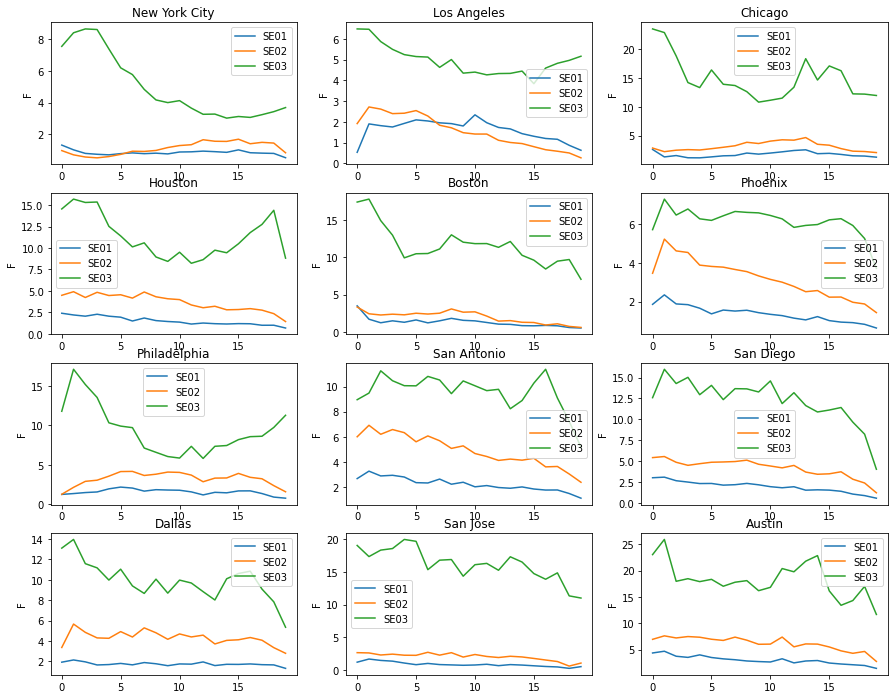

In [28]:
income = ['SE01', 'SE02', 'SE03']

plt.figure(figsize=(15, 12))
for i, j in enumerate(all_cityF):
    ax = plt.subplot(4, 3, i+1)
    
    for k in range(3):
        ax.plot(all_cityF[i][k]['F'], label=income[k])
    
    ax.set_title(cities[i][0])
    ax.set_ylabel('F')
    ax.legend()